# TSNE egde types visualizations

In [1]:
import os
from glob import glob
from tqdm.auto import tqdm
import numpy as np
from ensmallen_graph import EnsmallenGraph
from embiggen import LinkPredictionSequence

Here we are going to use the [tsne-cuda](https://github.com/CannyLab/tsne-cuda) implementation from Berkeley, which is the fastest I know.

Since it may be not the easiest one to install, we make available all the rendered tsne embeddings in the folder "tsne" within the same repository.

In [2]:
try:
    from tsnecuda import TSNE
except ModuleNotFoundError:
    from MulticoreTSNE import MulticoreTSNE as TSNE

We retrieve all the embeddings to further embed using TSNE

In [3]:
paths = glob("*_embedding.npy")

We load the graph:

In [4]:
graph = EnsmallenGraph.from_csv(
    edge_path="../data/ppi/edges.tsv",
    sources_column="subject",
    destinations_column="object",
    directed=False,
)

In [5]:
def generate_edge_embeddings(max_edges: int, path:str, graph:EnsmallenGraph, negative_samples:float=1.0, method:str="hadamard"):
    """Return random edge embeddings and their label.
    
    Parameters
    --------------------
    max_edges: int,
        Maximum number of edges to generate.
        Most likely the generated edges will be less, as some negative edges will
        be generated over the positive once and will get filtered out and not regenerated.
    path:str,
        Path from where to load the embedding.
    graph:EnsmallenGraph,
        Graph from where to extract the edges.
    negative_samples:float=2.0,
        Unbalance factor between positive (existing) and negative (non-existing) edges.
    
    Returns
    ---------------------
    Tuple with embeddings and their labels.
    """
    return LinkPredictionSequence(
        graph,
        np.load(path),
        method=method,
        negative_samples=negative_samples,
        batch_size=max_edges,
    )[0]

## Executing the TSNE embeddings

We compute TSNE for different values of perplexity to check if the embedding is stable.

In [6]:
edges_to_sample = 200000

os.makedirs("tsne_edges", exist_ok=True)

for path in tqdm(paths, desc="Embedding all paths"):
    for method in tqdm(LinkPredictionSequence.methods, desc="Methods", leave=False):
        tsne_path = f"tsne_edges/{method}_{path}"
        if os.path.exists(tsne_path):
            continue
        edges, classes = generate_edge_embeddings(
            edges_to_sample,
            path,
            graph,
            method=method
        )
        np.save(f"tsne_edges/{method}_labels_{path}", classes)
        tsne = TSNE(verbose=True)
        np.save(
            tsne_path,
            tsne.fit_transform(edges)
        )

In [10]:
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, ListedColormap

# TODO: Move this method into embiggen
def plot_edge_embedding(
    tsne_embedding:np.ndarray,
    labels:np.ndarray,
    axes:Axes=None
):
    if axes is None:
        _, axes = plt.subplots(figsize=(5,5))
        
    colors = list(TABLEAU_COLORS.keys())[:2]
    
    index = np.arange(labels.size)
    np.random.shuffle(index)
    
    tsne_embedding = tsne_embedding[index]
    labels = labels[index]
    
    scatter = axes.scatter(
        *tsne_embedding.T,
        s=0.01,
        c=labels,
        cmap=ListedColormap(colors)
    )
    axes.legend(
        handles=scatter.legend_elements()[0],
        labels=["Negative", "Positive"]
    )
    return axes

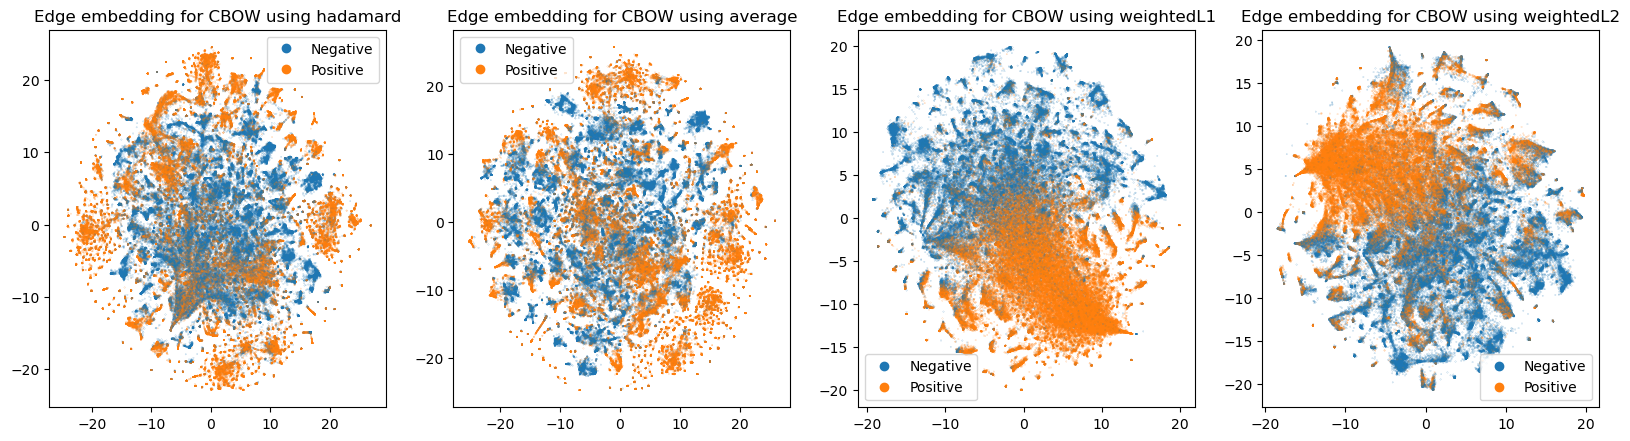

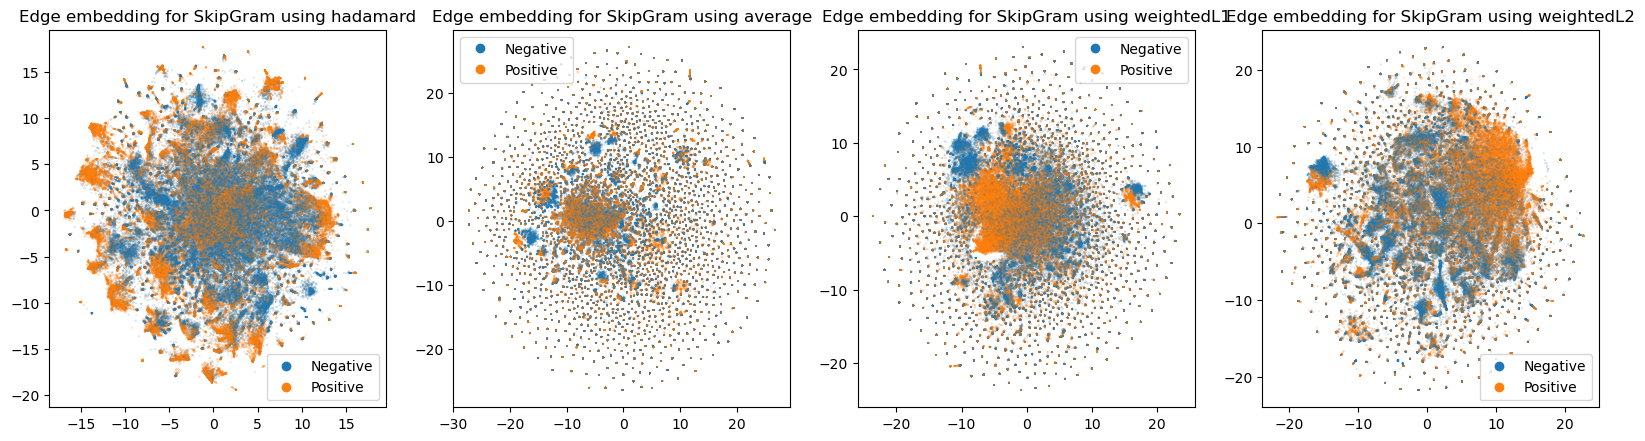

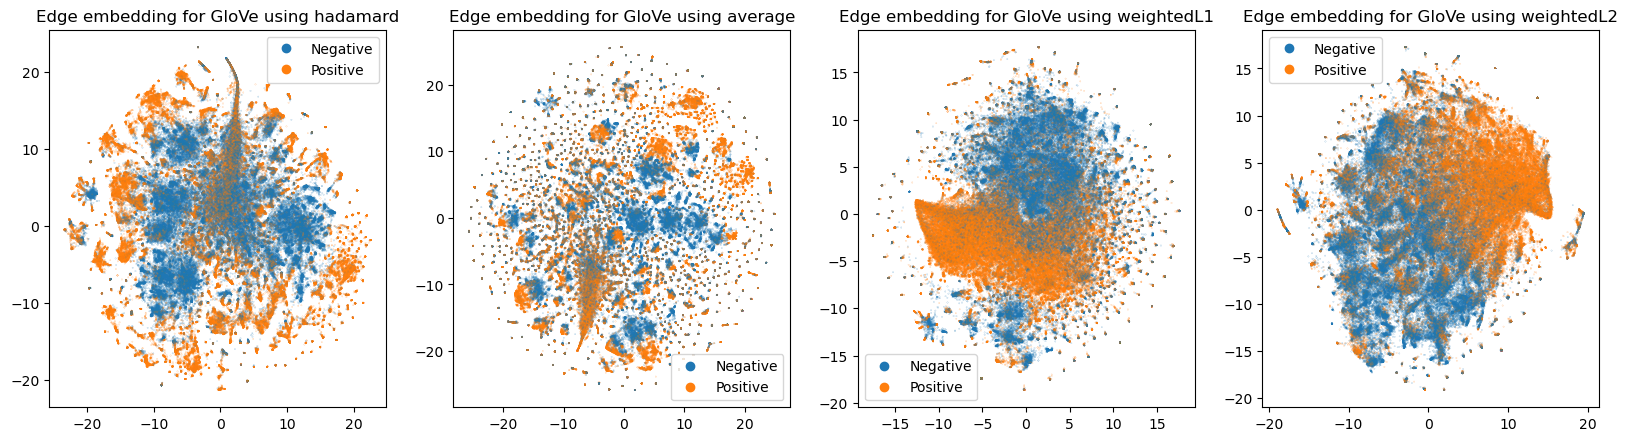

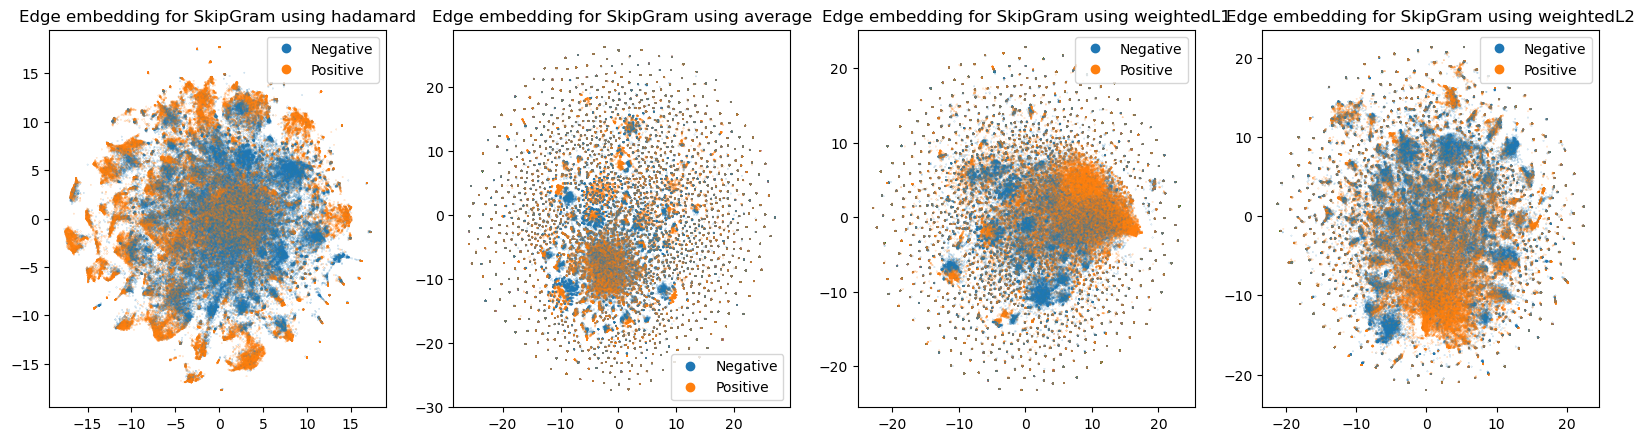

In [11]:
for path in tqdm(paths, desc="Drawing all embeddings"):
    fig, axes_row = plt.subplots(
        ncols=len(LinkPredictionSequence.methods),
        figsize=(5*len(LinkPredictionSequence.methods), 5),
        dpi=100
    )
    for method, axes in zip(LinkPredictionSequence.methods, axes_row):
        tsne_embedding = np.load(f"tsne_edges/{method}_{path}")
        labels = np.load(f"tsne_edges/{method}_labels_{path}")
        plot_edge_embedding(
            tsne_embedding,
            labels,
            axes=axes
        )
        axes.set_title(f"Edge embedding for {path.split('_')[0]} using {method}")
    plt.show()